# Relatedness Tutorial

This notebook demonstrates a variety of approaches for calculating relationship matrices in [sgkit](https://pystatgen.github.io/sgkit).
It covers the following topics:

- Working with pedigree data
    - Reading generic pedigree formats
    - Pedigree structure in sgkit
- Pedigree estimation of additive relationships
- Working with genomic variants
    - Reading a SNP-matrix
    - Creating a SNP-dosage array in sgkit
- Genomic estimation of additive relationships
    - The VanRaden estimator
    - The Weir-Goudet estimator
- Hybrid relationship matrices
    - Merging arrays between datasets

*Note that sgkit is still a 0.x release and its API is subject to non-backwards compatible changes.*

## Download the pig dataset

This notebook uses a dataset published by Cleveland et al (2012).
The full dataset includes pedigree information for 6473 pigs and SNP calls for a 3534 of the pedigreed individuals across 52843 biallelic loci.
Only the first 10000 SNPs are used within this tutorial.

First, download the data locally:

In [1]:
from pathlib import Path
import requests


if not Path("Cleveland2012_pedigree.txt.gz").exists():
    response = requests.get("https://storage.googleapis.com/sgkit-data/tutorial/Cleveland2012_pedigree.txt.gz")
    with open("Cleveland2012_pedigree.txt.gz", "wb") as f:
        f.write(response.content)
if not Path("Cleveland2012_snps1000.txt.gz").exists():
    response = requests.get("https://storage.googleapis.com/sgkit-data/tutorial/Cleveland2012_snps1000.txt.gz")
    with open("Cleveland2012_snps1000.txt.gz", "wb") as f:
        f.write(response.content)

Now we can import sgkit and inspect the dataset. We will also import a few other commonly used libraries.

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import sgkit as sg
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

## Reading pedigree data

We will start by looking at the pedigree data.
Pedigrees are commonly stored as simple tabular files with three primary columns corresponding to individual identifiers and their paternal and maternal parents.
While there is some standardization of these files (see the [ped format](https://gatk.broadinstitute.org/hc/en-us/articles/360035531972-PED-Pedigree-format)), they can be quite variable.
For this reason, sgkit does not have a generic pedigree IO functions and we instead recommend using [pandas](https://pandas.pydata.org/). 

In [3]:
pedigree = pd.read_csv("Cleveland2012_pedigree.txt.gz")
pedigree.head()

ID  SIRE  DAM
0   1     0    0
1   2     0    0
2   3     0    0
3   4     0    0
4   5     0    0

We can see that the samples have integer IDs which appear to be in ascending order starting from 1. It is also common to use a 0 to indicate an unknown parent in pedigree files.

While sgkit can support integer identifiers, it's often safer to treat them as strings which ensures that they are not mistaken for sample *indices*.
This is especially true when sample IDs are one-based integers rather than the zero-based indices used in python.
This also allows us to replace zeros with `'.'` which is the default approach for representing missing strings in sgkit (following the VCF standard).

In [4]:
pedigree = pedigree.astype("U").set_index("ID", drop=True).replace("0", ".")
pedigree.head()

SIRE DAM
ID         
1     .   .
2     .   .
3     .   .
4     .   .
5     .   .

Next we convert the pandas dataframe to an xarray data array.
This is referred to as the [`parent_id`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.variables.parent_id_spec.html#sgkit.variables.parent_id_spec) matrix in sgkit and has dimensions named "samples" and "parents".

In [5]:
parent_id = xr.DataArray(pedigree, dims = ("samples", "parents"))
parent_id

<xarray.DataArray (samples: 6473, parents: 2)>
array([['.', '.'],
       ['.', '.'],
       ['.', '.'],
       ...,
       ['4279', '6465'],
       ['6466', '1129'],
       ['5129', '6472']], dtype=object)
Coordinates:
  * samples  (samples) object '1' '2' '3' '4' ... '6470' '6471' '6472' '6473'
  * parents  (parents) object 'SIRE' 'DAM'

Note that the index column of the pedigree dataframe (containing the sample IDs) has been translated to *coordinates* for the "samples" dimension of the data array.
Likewise, the column names have been used as coordinates of the "parents" dimension.

Finally we create a Dataset.
We will call this dataset `ped` to indicate that it primarily contains the pedigree data, and to differentiate it from a dataset containing genomic data that will be created later in this notebook.

In addition to adding the `parent_id` matrix to the dataset, we will also create a [`sample_id`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.variables.sample_id_spec.html#sgkit.variables.sample_id_spec) array which is expected by many sgkit methods.
Fortunately the `sample_id` array is identical to the "samples" coordinate of the `parent_id` matrix.

In [6]:
ped = xr.Dataset()
ped["sample_id"] = parent_id.samples
ped["parent_id"] = parent_id
ped

<xarray.Dataset>
Dimensions:    (samples: 6473, parents: 2)
Coordinates:
  * samples    (samples) object '1' '2' '3' '4' ... '6470' '6471' '6472' '6473'
  * parents    (parents) object 'SIRE' 'DAM'
Data variables:
    sample_id  (samples) object '1' '2' '3' '4' ... '6470' '6471' '6472' '6473'
    parent_id  (samples, parents) object '.' '.' '.' ... '1129' '5129' '6472'

## Working with pedigree data

In sgkit, a pedigree is defined by the combination of the `sample_id` and `parent_id` variables.
The `sample_id` array must contain unique identifiers for each sample.
The `parent_id` matrix has one row for each sample and (typically) two columns, one for each parent.
The values of the `parent_id` matrix must be values found in `sample_id` with the exception of "missing" or "unknown" parents which are normally encoded as `"."`.

Pedigree methods in sgkit use these variables to generate the [`parent`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.variables.parent_spec.html) matrix which has the same shape as `parent_id` but contains the integer *indices* of each parent with `-1` indicating unknown parents.
It is important to note that adding, removing or re-ordering samples in the dataset will invalidate these indices and they should be re-created using the `parent_indices` method.

In [7]:
ped = sg.parent_indices(ped)
ped.parent

<xarray.DataArray 'parent' (samples: 6473, parents: 2)>
array([[  -1,   -1],
       [  -1,   -1],
       [  -1,   -1],
       ...,
       [4278, 6464],
       [6465, 1128],
       [5128, 6471]])
Coordinates:
  * samples  (samples) object '1' '2' '3' '4' ... '6470' '6471' '6472' '6473'
  * parents  (parents) object 'SIRE' 'DAM'
Attributes:
    comment:  Indices of parent samples with negative values indicating unkno...

The `parent_id` matrix serves as a robust record of the pedigree structure which preserves the structure of a pedigree if the dataset is subset or reordered.
The `parent` matrix contains integer indices of the parent samples within the dataset allowing for fast numerical calculations.
However, any changes to the ordering of samples within the dataset will invalidate the indices within the `parent` matrix.

## Pedigree relationships

Pedigree based estimates of relatedness are an *expectation* of the relationships among individuals.
These expectations are based on some simplifying assumptions, the most important of which are that the pedigree is correct and that the founding individuals of the pedigree are *equally unrelated* from one another.
Even when these assumptions hold, pedigree based estimates of relatedness will be slightly inaccurate as they ignore variance around the expectation caused by Mendelian sampling. 

Using our pedigree dataset, we can calculate the additive relationship matrix (ARM) using the [`predigree_kinship`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.pedigree_kinship.html) method.

In [8]:
ped = sg.pedigree_kinship(
    ped,
    allow_half_founders=True,  # allow samples with a single unknown parent
    return_relationship=True,  # return the additive relationship matrix in addition to the kinship matrix
)

This returns a dataset with variables [`stat_pedigree_kinship`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.variables.stat_pedigree_kinship_spec.html) and [`stat_pedigree_relationship`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.variables.stat_pedigree_relationship_spec.html).

In [9]:
ped.stat_pedigree_relationship

<xarray.DataArray 'stat_pedigree_relationship' (samples_0: 6473, samples_1: 6473)>
dask.array<mul, shape=(6473, 6473), dtype=float64, chunksize=(6473, 6473), chunktype=numpy.ndarray>
Dimensions without coordinates: samples_0, samples_1
Attributes:
    comment:  Relationship matrix derived from pedigree structure.

Note that the dimensions of the matrices are called `samples_0` and `samples_1` to avoid using a single dimension twice in an xarray DataArray.
Unfortunately, this means that the coordinates of the `samples` array have not been propagated to the new dimensions.
We can do this now by using the `assign_coords()` method.

In [10]:
ped = ped.assign_coords(dict(samples_0=ped.samples.values, samples_1=ped.samples.values))

sgkit makes use of [dask](https://www.dask.org/) for lazy, distributed, computation.
This means that sgkit methods return dask arrays rather than numpy arrays.
You can think of a dask array as a "promise" to compute the data at a later point, rather than immediately evaluating the result.
In this case we want to inspect the results immediately so we can use the `compute()` method to evaluate all dask arrays in the dataset.

In [11]:
ped = ped.compute()
ped.stat_pedigree_relationship

<xarray.DataArray 'stat_pedigree_relationship' (samples_0: 6473, samples_1: 6473)>
array([[1.        , 0.        , 0.        , ..., 0.015625  , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.015625  , 0.        , 0.        , ..., 1.01111412, 0.01885986,
        0.01507568],
       [0.        , 0.        , 0.        , ..., 0.01885986, 1.        ,
        0.5324707 ],
       [0.        , 0.        , 0.        , ..., 0.01507568, 0.5324707 ,
        1.0324707 ]])
Coordinates:
  * samples_0  (samples_0) object '1' '2' '3' '4' ... '6471' '6472' '6473'
  * samples_1  (samples_1) object '1' '2' '3' '4' ... '6471' '6472' '6473'
Attributes:
    comment:  Relationship matrix derived from pedigree structure.

We can plot the relationship using matplotlib.

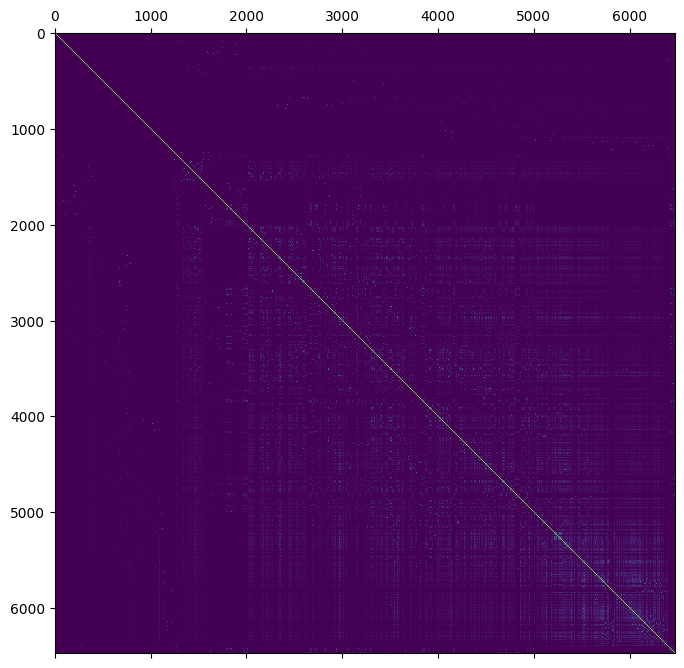

In [12]:
plt.matshow(ped.stat_pedigree_relationship)
plt.show()

## Genomic relationships

Genomic estimation of relatedness attempts to estimate the *realized* relationships among individuals based upon shared alleles.
To calculate genomic relationship estimates, we first need to read in the genomic marker data and construct a new dataset.
sgkit includes [IO methods](https://pystatgen.github.io/sgkit/latest/api.html#io-imports-and-exports) for several  common datatype including BGEN, PLINK and VCF.
However, it is also possible to load data from other formats by manually constructing the required data arrays.

The pig SNP data used in this tutorial is provided as a simple text file of SNP dosages.
We can read in the data using pandas.

In [13]:
snps = pd.read_csv(
    "Cleveland2012_snps1000.txt.gz", 
    index_col=0, 
)
snps.head()

1    2    3    4    5    6    7    8    9   10  ...  991  992  993  \
ID                                                     ...                  
584  1.0  1.0  1.0  2.0  1.0  0.0  2.0  1.0  2.0  2.0  ...  2.0  2.0  2.0   
585  0.0  2.0  1.0  2.0  0.0  0.0  1.0  1.0  1.0  1.0  ...  2.0  2.0  1.0   
587  2.0  2.0  0.0  1.0  1.0  0.0  2.0  2.0  2.0  1.0  ...  2.0  2.0  0.0   
588  1.0  1.0  1.0  0.0  0.0  0.0  1.0  2.0  2.0  2.0  ...  2.0  2.0  1.0   
589  0.0  1.0  2.0  2.0  1.0  0.0  2.0  2.0  2.0  2.0  ...  1.0  2.0  1.0   

     994  995  996  997  998  999  1000  
ID                                       
584  0.0  2.0  0.0  2.0  2.0  2.0   2.0  
585  0.0  0.0  0.0  2.0  0.0  2.0   1.0  
587  0.0  1.0  0.0  1.0  1.0  2.0   1.0  
588  0.0  0.0  0.0  2.0  0.0  2.0   2.0  
589  0.0  2.0  0.0  1.0  0.0  2.0   1.0  

[5 rows x 1000 columns]

Loading the data results in a matrix of SNP dosages (sometimes referred to as a SNP-matrix).
Rows of the matrix correspond to individuals using the same identifiers as in the pedigree, and columns correspond to marker loci.

To work with this data in sgkit, we will translate it into the [`call_dosage`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.variables.call_dosage_spec.html) variable.
This requires that we transpose the matrix so that rows correspond to variant loci and columns correspond to samples. 

In [14]:
snps.index = snps.index.astype("U")  # convert sample identifiers to strings to match pedigree
call_dosage = xr.DataArray(snps.T, dims = ("variants", "samples"))  # transpose matrix and convert to xarray
call_dosage

<xarray.DataArray (variants: 1000, samples: 3534)>
array([[1., 0., 2., ..., 0., 1., 0.],
       [1., 2., 2., ..., 1., 1., 2.],
       [1., 1., 0., ..., 1., 2., 2.],
       ...,
       [2., 0., 1., ..., 0., 0., 0.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 1., 1., ..., 0., 2., 0.]])
Coordinates:
  * variants  (variants) object '1' '2' '3' '4' '5' ... '997' '998' '999' '1000'
  * samples   (samples) object '584' '585' '587' '588' ... '6470' '6471' '6473'

Next we create a dataset containing the `call_dosage` and `sample_id` variables.

In [15]:
gen = xr.Dataset()
gen["sample_id"] = call_dosage.samples
gen["call_dosage"] = call_dosage
gen

<xarray.Dataset>
Dimensions:      (samples: 3534, variants: 1000)
Coordinates:
  * samples      (samples) object '584' '585' '587' ... '6470' '6471' '6473'
  * variants     (variants) object '1' '2' '3' '4' ... '997' '998' '999' '1000'
Data variables:
    sample_id    (samples) object '584' '585' '587' ... '6470' '6471' '6473'
    call_dosage  (variants, samples) float64 1.0 0.0 2.0 1.0 ... 0.0 0.0 2.0 0.0

## The VanRaden GRM

The first estimator described by VanRaden (2008) is one of the most widely used methods for calculating a genomic relationship matrix. 
This estimator is defined in terms of a dosage or "SNP-matrix". 
This is a $n \times m$ matrix where $n$ is the number of single nucleotide variants and $m$ is the number samples. 
Each value in this matrix indicates the number of alternate (or reference) alleles found within a samples genotype at that variant locus.
These values should be `0`, `1` or `2` for diploid genotypes (respectively indicating homozygous reference, heterozygous and homozygous alternate).
In sgkit, the `call_dosage` array serves this purpose.

In addition to SNP dosages, the method also requires *ancestral* or *base* alternate allele frequencies for the population that has been sampled:
> "Allele frequencies in P should be from the unselected base population rather than those that occur after selection or inbreeding" VanRaden (2008)

However, it is common practice (though not necessarily *best* practice) to use the sample-population allele frequencies instead.
The sample-population allele frequencies can be a reasonable estimate of the base population allele frequencies in natural populations.
They are less likely to be reasonable in a non-randomly selected sample-population such as a pig breeding program.

*Note that it is common practice to filter variants by minor allele frequency when applying the VanRaden estimator as it is sensitive to rare alleles.
We don't do any such filtering here.*

We will initially calculate a "naive" version of the VanRaden estimator by using the sample-population allele frequencies as the ancestral frequencies.
This is achieved by taking the mean dosage across the sample population and dividing by the ploidy (2).

In [16]:
gen["sample_frequency"] = gen.call_dosage.mean(dim="samples") / 2

The estimate is then calculated with the [`genomic_relationship`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.genomic_relationship.html) method which returns a matrix called [`stat_genomic_relationship`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.variables.stat_genomic_relationship_spec.html).
However, we will rename this matrix to `"stat_VanRaden_GRM_naive"` for clarity.

In [17]:
gen["stat_VanRaden_GRM_naive"] = sg.genomic_relationship(
    gen,
    call_dosage="call_dosage",
    ancestral_frequency="sample_frequency",
    ploidy=2,
    merge=False,  # return a dataset containing only the genomic relationship matrix
).stat_genomic_relationship.compute()

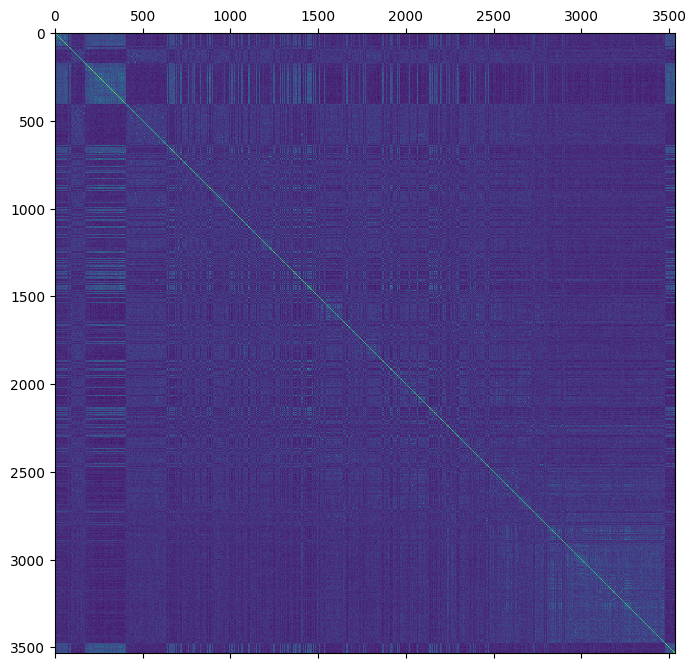

In [18]:
plt.matshow(gen.stat_VanRaden_GRM_naive)
plt.show()

How do the genomic estimates compare to the pedigree estimates?
To compare the two estimates we need to select the pedigree estimates for the subset of samples with genomic estimates and merge them into the genomic dataset.
Xarrays `merge` method is perfect for this task, so long as we have set the sample names as coordinates for the relevant dimensions.

In [19]:
gen = gen.assign_coords(dict(samples_0=gen.samples.values, samples_1=gen.samples.values))
gen = gen.merge(ped.stat_pedigree_relationship, join="left")

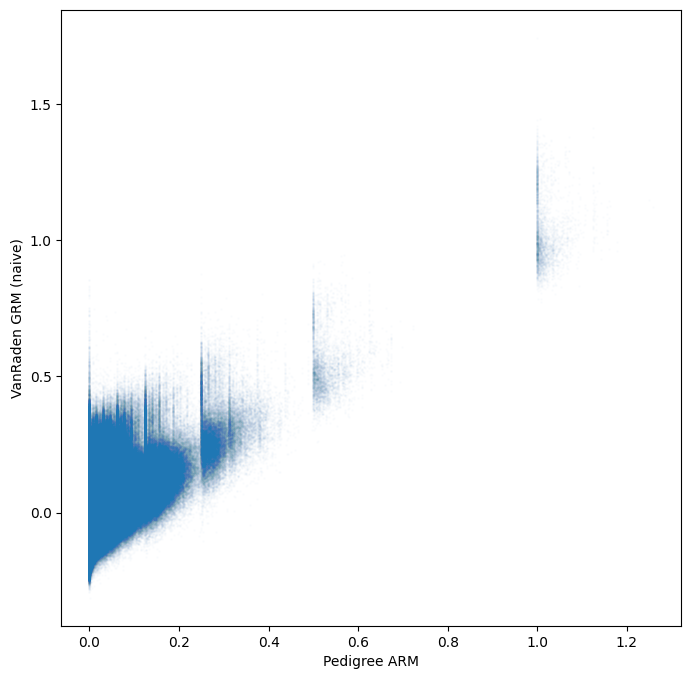

In [20]:
tril_idx = np.tril_indices(gen.dims["samples"])
plt.scatter(
    gen.stat_pedigree_relationship.values[tril_idx], 
    gen.stat_VanRaden_GRM_naive.values[tril_idx], 
    s=1, 
    alpha=0.01,
)
plt.xlabel("Pedigree ARM")
plt.ylabel("VanRaden GRM (naive)")
plt.show()

## A better estimate of ancestral allele frequencies

We could potentially improve the genomic relationship estimates if we had a better estimate of the ancestral allele frequencies.
To this end, we could make use of the pedigree data to identify individuals whose genotypes are more likely to represent the ancestral/base population.
For example, if a pair of pigs were selected for crossing and produced 10 progeny, then the allele frequencies of those progeny will not give us any additional information about the base allele frequencies that wasn't already present in their parents.
In fact, including the progeny will potentially *bias* our estimate of the ancestral allele frequencies by increasing the apparent frequency of alleles found in their parents.
Hence, a better estimate of ancestral allele frequencies could be obtained by using the mean allele frequency of the founding individuals of the pedigree.
Unfortunately, not all of the pedigree founders have been genotyped, so we would still need to use some progeny as "surrogates".

McPeek et al (2004) describe the best linear unbiased estimate (BLUE) of allele frequencies using pedigree data.
Their method uses the inverse of the pedigree kinship estimates to generate a weight for each individual of the sample population.
These weights are then used to calculate weighted mean allele frequencies which should better reflect the ancestral/base population.
Their equation is given

$$
\hat{a} = (\textit{1}^\intercal \phi^{-1} \textit{1})^{-1} \textit{1}^\intercal \phi^{-1} X
$$

where $\phi$ is a kinship matrix estimated from the pedigree, $\textit{1}$ is a column vector of ones and $X$ is a matrix of sample allele frequencies.

Although the McPeek estimator is not implemented in sgkit, it is straightforward to calculate using standard array operations.
First, we need to merge in the pedigree kinship estimates ($\phi$) from the pedigree dataset to get the pedigree kinships for the subset of samples that have been genotyped (Note that the inverse of a sub-matrix is not equal to a sub-matrix of an inverse!).

In [21]:
gen = gen.merge(ped.stat_pedigree_kinship, join="left")

We then invert the pedigree kinship estimates to get $\phi^{-1}$

In [22]:
gen["stat_inverse_pedigree_kinship"] = sg.invert_relationship_matrix(
    gen, 
    relationship="stat_pedigree_kinship", 
    merge=False,
).stat_inverse_relationship.compute()

Next, we divide the sum of each row by the sum of the whole matrix to get the weighting for each sample

In [23]:
gen["blue_weights"] = gen.stat_inverse_pedigree_kinship.sum(dim="samples_0").rename(samples_1="samples") / gen.stat_inverse_pedigree_kinship.sum()

Finally we calculate the BLUE of ancestral allele frequencies using those weights

In [24]:
gen["blue_frequency"] = (gen.call_dosage * gen.blue_weights).sum(dim="samples") / 2

And re-calculate the VanRaden estimator

In [25]:
gen["stat_VanRaden_GRM_blue"] = sg.genomic_relationship(
    gen,
    call_dosage="call_dosage",
    ancestral_frequency="blue_frequency",
    ploidy=2,
    merge=False,
).stat_genomic_relationship.compute()

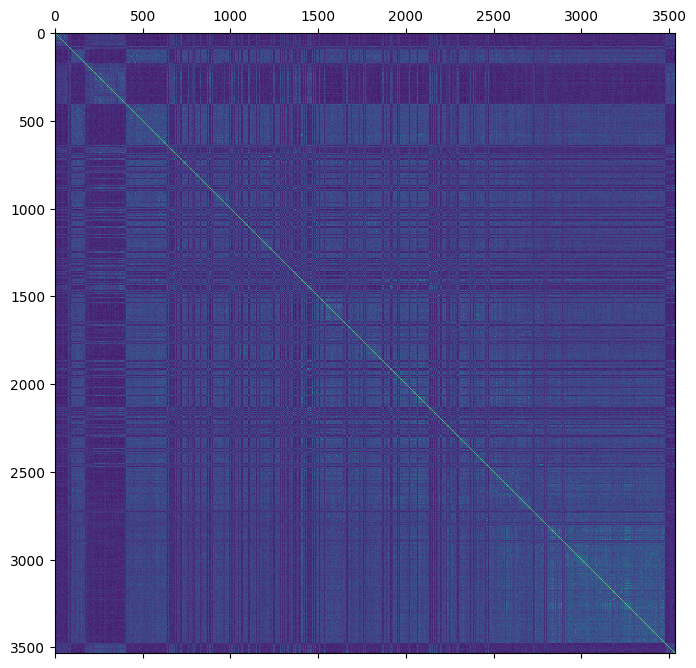

In [26]:
plt.matshow(gen.stat_VanRaden_GRM_blue)
plt.show()

The new genomic estimate appears to be more consistent with the pedigree based estimate

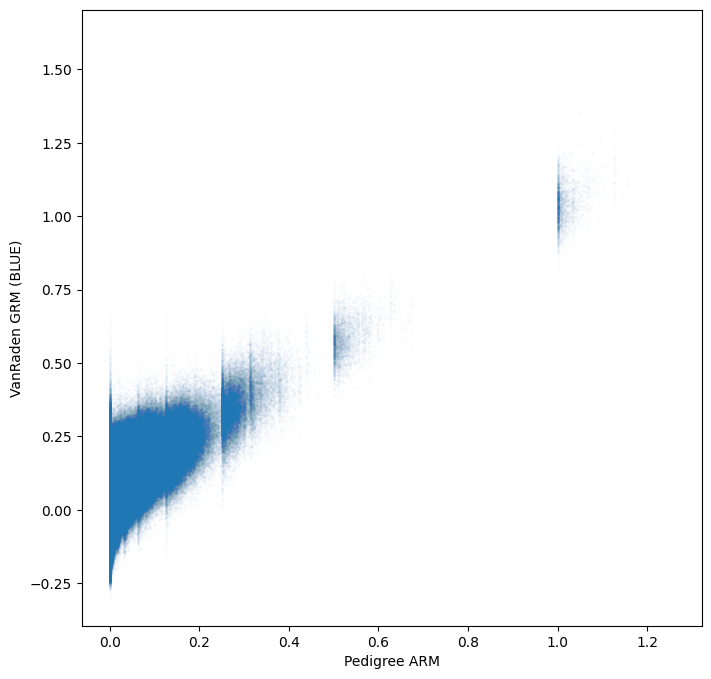

In [27]:
tril_idx = np.tril_indices(gen.dims["samples"])
plt.scatter(
    gen.stat_pedigree_relationship.values[tril_idx], 
    gen.stat_VanRaden_GRM_blue.values[tril_idx], 
    s=1, 
    alpha=0.01,
)
plt.xlabel("Pedigree ARM")
plt.ylabel("VanRaden GRM (BLUE)")
plt.show()

## Weir-Goudet GRM

Weir and Goudet (2017) describe an alternate approach to estimating kinship and relatedness. In simple terms, their approach estimates a "matching" coefficient (pairwise probabilities of identity by state) and then scales these values such that they approximate probabilities of IBD (identity by descent).
By default, they scale these probabilities by the average matching coefficient *between* pairs of individuals in the sample-population.
This estimates a term referred to as $\beta$ (beta) which is the kinship relative to the mean kinship among the sample-population.
If individuals within the sample population are, on average, unrelated to one another, then $\beta$ is an estimate of kinship.

If individuals of the sample population are related to one another (relative to a reference population), then $\beta$ will be biased and underestimate kinship.
However, equation 11 in Weir and Goudet (2017) can be used to correct $\beta$ based upon prior knowledge of the population structure.
This equation is given

$$
\hat{\beta}^c=\frac{\hat{\beta}-\hat{\beta}_0}{1-\hat{\beta}_0}
$$

where $\hat{\beta}_0$ is the estimate of $\beta$ between individuals that are known to be unrelated (with respect to a reference population).
Importantly, the scaling of this estimator does not affect the *rank-order* of relationships.

We can calculate the Weir-Goudet estimator using the [`Weir_Goudet_beta`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.Weir_Goudet_beta.html) method.
This method uses sample allele-frequencies rather than dosage because it can be applied to multi-allelic data.
Therefore, we first convert the `call_dosage` variable to the [`call_allele_frequency`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.variables.call_allele_frequency_spec.html) variable which holds per sample allele frequencies for both the reference and alternate alleles.

In [28]:
gen["call_allele_frequency"] = xr.concat(
    [1 - gen.call_dosage / 2, gen.call_dosage / 2],
    dim="alleles",
).transpose("variants", "samples", "alleles")

Then we compute the Weir-Goudet $\beta$ estimate and multiply by two to get the (diploid) un-corrected relationship matrix.

In [29]:
gen = sg.Weir_Goudet_beta(gen).compute()
gen["stat_Weir_Goudet_GRM"] = gen.stat_Weir_Goudet_beta * 2

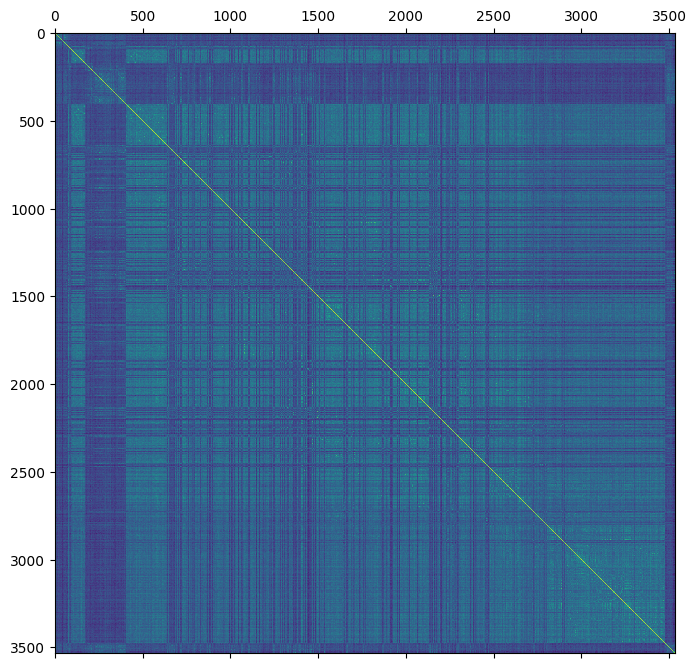

In [30]:
plt.matshow(gen.stat_Weir_Goudet_GRM)
plt.show()

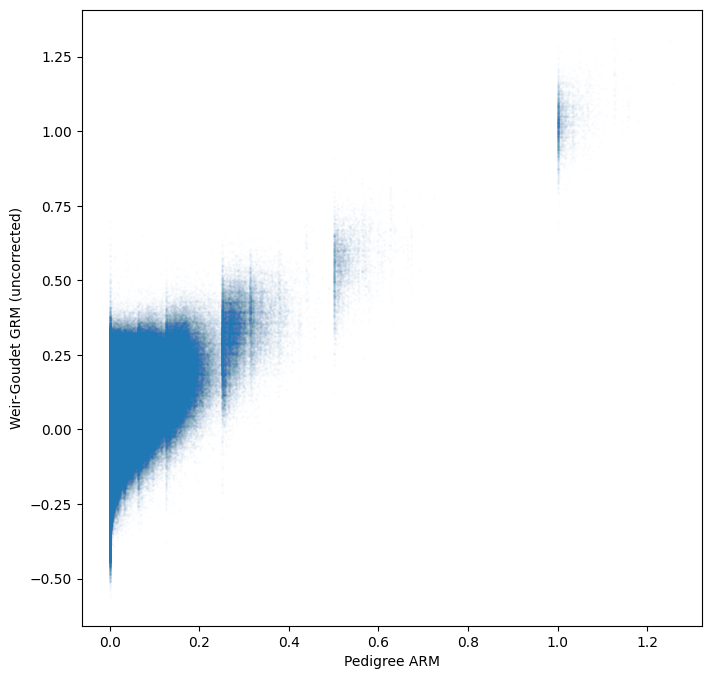

In [31]:
tril_idx = np.tril_indices(gen.dims["samples"])
plt.scatter(
    gen.stat_pedigree_relationship.values[tril_idx], 
    gen.stat_Weir_Goudet_GRM.values[tril_idx], 
    s=1, 
    alpha=0.01,
)
plt.xlabel("Pedigree ARM")
plt.ylabel("Weir-Goudet GRM (uncorrected)")
plt.show()

## Hybrid relationship matrices

In plant and animal breeding, we often have genomic data for only a subset of the population we are studying. 
This may be due to budget limitations, time constraints or because some individuals are deceased.
However, we typically have pedigree data available for the full population in question.
Rather than choosing between the pedigree relationship matrix (A-matrix) or a smaller genomic relationship matrix (G-matrix),
we would like to combine these matrices into a "hybrid" relationship matrix (H-matrix).
The motivation for creating an H-matrix is (usually) to combine the accuracy and detail of a G-matrix with the completeness of the A-matrix.
You may think of this process as using the pedigree information to "project" the G-matrix across non-genotyped individuals.

In sgkit, we use a `nan` values to indicate missing relationships in the G-matrix (i.e., for pairs of sample in which at least one sample does not have genomic data).
We can use a simplified representation of this matrix

$$
\begin{bmatrix}
nan_{11} & nan_{21}\\
nan_{12} & G
\end{bmatrix}
$$

where $nan_{11}$, $nan_{12}$ and $nan_{21}$ represent sub-matrices containing nan values and $G$ is the sub-matrix of genomic relationships for genomic samples.

We can create this `nan`-padded matrix by merging the G-matrix into the full pedigree dataset (note the use of `join="left"` to ensure that sample ordering of the pedigree dataset is not changed).

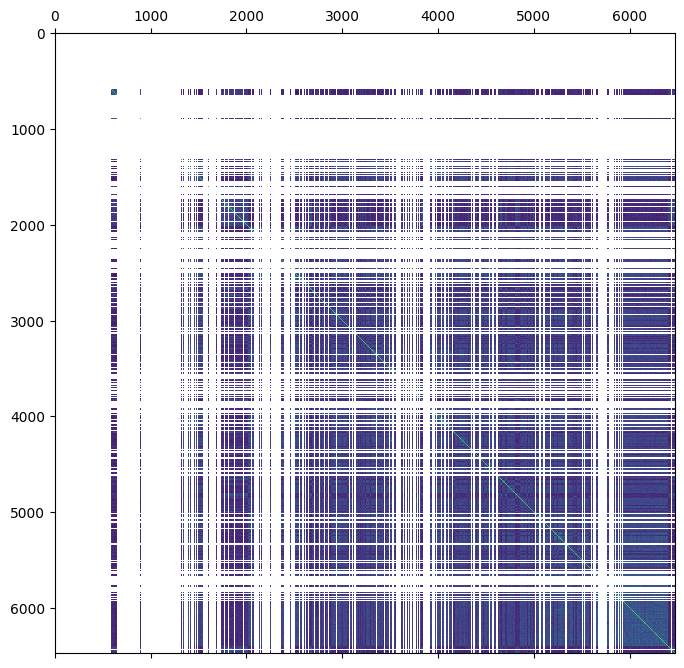

In [32]:
ped = ped.merge(gen.stat_VanRaden_GRM_blue, join="left")
plt.matshow(ped.stat_VanRaden_GRM_blue)
plt.show()

This is much messier than the matrix notation!
The 'gaps' in the above image correspond to `nan` values.
For the sake of efficiency, we also need to create an array which indicates which samples do have genomic estimates.

In [33]:
ped["genomic_sample"] = ped.sample_id.isin(gen.sample_id)

The pedigree dataset already contains the pedigree relationship matrix created earlier in this tutorial.
This matrix does not have any missing data and can be represented using the notation

$$
\begin{bmatrix}
A_{11} & A_{21}\\
A_{12} & A_{22}
\end{bmatrix}
$$

where $A_{11}$ corresponds to $nan_{11}$, $A_{12}$ corresponds to $nan_{12}$ and $A_{22}$ corresponds to $G$.
The goal of creating a hybrid relationship matrix is to update $A_{11}$, $A_{12}$ and $A_{21}$ with information from $G$.
By default, the sub-matrix $A_{22}$ is effectively replaced with $G$ such that

$$
H=
\begin{bmatrix}
H_{11} & H_{21}\\
H_{12} & H_{22}
\end{bmatrix}
=
\begin{bmatrix}
H_{11} & H_{21}\\
H_{12} & G
\end{bmatrix}
$$

However, the scaling factors $\tau$ and $\omega$ (Martini et al 2018) can be used to fine-tune the influence of $A$ and $G$ in which case $H_{22}$ may differ from $G$ (the use of these scaling factors are beyond the scope of this tutorial).

An H-matrix can be calculated using the [`hybrid_relationship`](https://pystatgen.github.io/sgkit/latest/generated/sgkit.hybrid_relationship.html) method.

*Note that we use the chunk method to ensure a single chunk along each axis. Due to the array size, dask will automatically chunk these matrix into uneven sizes resulting in an error raised during matrix inversion*

In [34]:
ped["stat_VanRaden_HRM_blue"] = sg.hybrid_relationship(
    ped.chunk(dict(samples_0=-1, samples_1=-1)),
    genomic_relationship="stat_VanRaden_GRM_blue",
    pedigree_relationship="stat_pedigree_relationship",
    genomic_sample="genomic_sample",
    merge=False,
).stat_hybrid_relationship.compute()

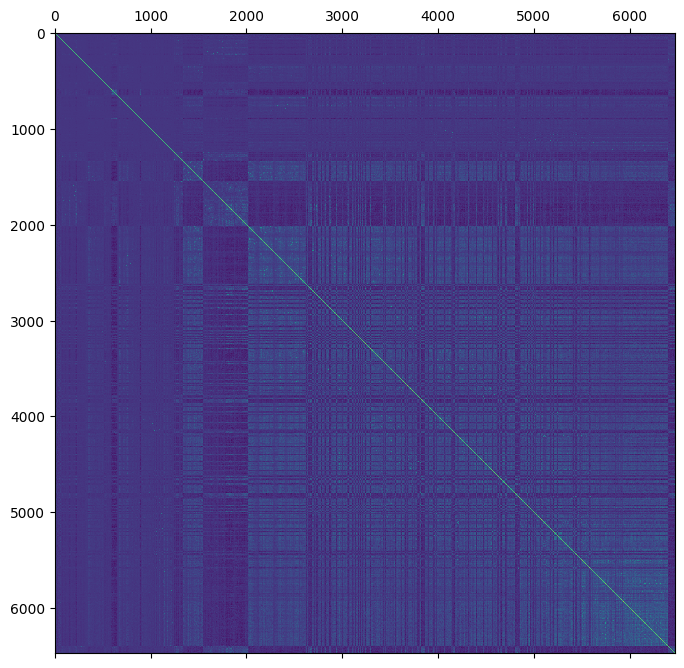

In [35]:
plt.matshow(ped.stat_VanRaden_HRM_blue)
plt.show()

We can verify that $H_{22}$ = $G$ using the indices of the genomic samples.

In [36]:
np.testing.assert_array_almost_equal(
    ped.stat_VanRaden_HRM_blue.loc[gen.samples.values, gen.samples.values],
    ped.stat_VanRaden_GRM_blue.loc[gen.samples.values, gen.samples.values],
)

## References

- Cleveland M, Hickey J and Forni S 2012 "A Common Dataset for Genomic Analysis of Livestock Populations" G3 2 429–435 https://doi.org/10.1534%2Fg3.111.001453.
- Martini J, Schrauf M, Garcia‑Baccino C, Pimentel E, Munilla S, Rogberg‑Muñoz A, Cantet R, Reimer C, Gao N, Wimmer V and Simianer H 2018 "The effect of the $H^{-1}$ scaling factors $\tau$ and $\omega$
    on the structure of $H$ in the single-step procedure." Genetics Selection Evolution 50  https://doi.org/10.1186/s12711-018-0386-x.
- McPeek M, Wu X and Ober C 2004 "Best Linear Unbiased Allele-Frequency Estimation in Complex Pedigrees" Biometrics 60 359–367 https://doi.org/10.1111/j.0006-341x.2004.00180.x.
- VanRaden P 2008 "Efficient Methods to Compute Genomic Predictions" Journal of Dairy Science 91 4414–4423 https://doi.org/10.3168/jds.2007-0980.
- Weir B and Goudet J 2017 "A Unified Characterization of Population Structure and Relatedness" Genetics 206 2085–2103 https://doi.org/10.1534/genetics.116.198424.